# Charts Deforestation

## 0. Reading data

In [3]:
from runner import io
import altair as alt
pantanal_deforestation_df = io.load_table("domain", "deforestation")
pantanal_df = io.load_table("domain", "pantanal")

In [4]:
pantanal_deforestation_df.head()

,year,location,city,area_ha,area_ha_lag,deforestation_ha,location_UF
0,1985-01-01,Aquidauana (MS),Aquidauana,724461.022516,NaN,0.000000,MS
1,1986-01-01,Aquidauana (MS),Aquidauana,724995.115856,724461.022516,0.000000,MS
2,1987-01-01,Aquidauana (MS),Aquidauana,722873.483044,724995.115856,2121.632812,MS
3,1988-01-01,Aquidauana (MS),Aquidauana,710701.701706,722873.483044,12171.781337,MS
4,1989-01-01,Aquidauana (MS),Aquidauana,701079.305726,710701.701706,9622.395981,MS


In [5]:
pantanal_df

,location,year,crop,area_ha,type,quantidade_ton,numero_cabecas
5105,Aquidauana (MS),1985,Arroz (em casca),NaN,temporario,1575.0,NaN
5111,Bodoquena (MS),1985,Arroz (em casca),NaN,temporario,2000.0,NaN
5122,Corumbá (MS),1985,Arroz (em casca),NaN,temporario,0.0,NaN
5124,Coxim (MS),1985,Arroz (em casca),NaN,temporario,9924.0,NaN
5144,Ladário (MS),1985,Arroz (em casca),NaN,temporario,0.0,NaN
...,...,...,...,...,...,...,...
194579,Itiquira (MT),2020,Bovino,NaN,pecuaria,NaN,336622.0
194587,Lambari D'Oeste (MT),2020,Bovino,NaN,pecuaria,NaN,161266.0
194596,Nossa Senhora do Livramento (MT),2020,Bovino,NaN,pecuaria,NaN,185903.0
194616,Poconé (MT),2020,Bovino,NaN,pecuaria,NaN,531977.0


## 1. Config Altair

In [6]:
# Databricks notebook source
# MAGIC %md # Altair setup

# COMMAND ----------

# MAGIC %sh
# MAGIC # Installing altair
# MAGIC /databricks/python/bin/pip install altair altair_saver selenium -q
# MAGIC 
# MAGIC # Installing chromewebdriver for saving altair plots
# MAGIC apt-get update -y
# MAGIC apt-get install -y chromium-browser chromium-chromedriver

# COMMAND ----------

from datetime import datetime, timedelta
import json

import pandas as pd
import numpy as np

import altair as alt
alt.data_transformers.disable_max_rows()
alt.renderers.set_embed_options(scaleFactor=5)

# COMMAND ----------

# Altair theme setup
def tfg_palette(key="tfg_dark_light"):
    color_schemes = {
        'category-6': ['#ec8431', '#829eb1', '#c89d29', '#3580b1', '#adc839', '#ab7fb4'],
        'fire-7': ['#fbf2c7', '#f9e39c', '#f8d36e', '#f4bb6a', '#e68a4f', '#d15a40', '#ab4232'],
        'fireandice-6': ['#e68a4f', '#f4bb6a', '#f9e39c', '#dadfe2', '#a6b7c6', '#849eae'],
        'ice-7': ['#edefee', '#dadfe2', '#c4ccd2', '#a6b7c6', '#849eae', '#607785', '#47525d'],
        "tfg_dark": ['#0C66B5', '#BA1D32', '#0F8E40', '#E56F20', '#862BAF', '#626D69', '#ED5087'],
        "tfg_light": ['#3DB9E2', '#51DB63', '#E26868', '#FFB270', '#B37CEA', '#A8A1A4', '#FF87CD'],
    }
    
    color_schemes["tfg_dark_light"] = color_schemes["tfg_dark"] + color_schemes["tfg_light"]
    
    return color_schemes[key]

def science_theme_title(
    font="Helvetica Neue",
    titleFontSize=18,
    subtitleFontSize=14,
    titleFontWeight="normal",
    text=None,
    subtitle=None,
    **kwargs
):
    title_dict = {
        "align": "left",
        "anchor": "start",
        "frame": "group",
        "font": font,
        "fontSize": titleFontSize,
        "dy": -2,
        # Doesn't work directly in config
        "subtitleFont": font,
        "subtitleFontSize": subtitleFontSize,
        "fontWeight": titleFontWeight,
    }
    
    if text is not None:
        title_dict["text"] = text

    if subtitle is not None:
        title_dict["subtitle"] = subtitle
    
    if kwargs:
        title_dict.update(kwargs)

    return title_dict

def science_theme(
    width=1600/3,
    height=900/3,
    font="Helvetica Neue",
    titleFontSize=18,
    titleFontWeight="bold",
    subtitleFontSize=14,
    baseFontSize=14,
):    

    return {
        "config": {
            "view": {
                "width": width,
                "height": height,
                "fill": "white",
            },
            "title": science_theme_title(
                font=font,
                titleFontSize=titleFontSize,
                subtitleFontSize=subtitleFontSize,
            ),
            "axis": {
                "domainColor": "lightGrey",
                "gridColor": "lightGrey",
                "gridWidth": 0.25,
#                 "title": None,
                "titleFont": font,
                "titleFontSize": baseFontSize - 3,
                "labelFont": font,
                "labelFontSize": baseFontSize,
            },
            "legend": {
                "layout": {"anchor": "start"},
                "labelLimit": 0,
                "titleFontSize": baseFontSize,
                "titleFont": font,
                "labelFontSize": baseFontSize,
                "labelFont": font,
            },
            "header": {
                "title": None,
                "titleFont": font,
                "labelFont": font,
                "labelFontSize": baseFontSize,
                "labelPadding": 2,
            },
            "range": {
                "category": tfg_palette(),
            },
        }
    }

def science_theme_caption(text):
    return (
        alt.Chart(pd.DataFrame(),
                  title={"text": text, **science_theme_title(titleFontSize=12, titleFontWeight="normal")})
        .mark_text()
        .properties(height=1, view={"stroke": None})
    )

def science_theme_facet_title_background(width, fill="lightGrey", opacity=0.25, widthExtra=1):
    return (
        alt.Chart(pd.DataFrame({"a": [0]}))
        .mark_rect(fill=fill, opacity=opacity)
        .encode(y=alt.value(-25), y2=alt.value(-1), x=alt.value(0), x2=alt.value(width + widthExtra))
    )

def science_theme_facet_plot(chart, 
                             title=None, subtitle=None, caption=None,
                             width=300, height=150,
                             facet_kwargs=None, facet_resolve_scales=None,
                             focus_chart=None, focus_chart_width=300, focus_chart_height=150,
                             focus_chart_title="All",
                             focus_chart_resolve_scales=None,
                             grey_facet_background=True,
                             configure_headerColumn=True,
                             **kwargs):
    
    if facet_kwargs is not None:
        if grey_facet_background:
          chart = (chart + science_theme_facet_title_background(width=width))
        chart = chart.facet(**facet_kwargs)

        if facet_resolve_scales is not None:
          chart = chart.resolve_scale(**facet_resolve_scales)
        
        if focus_chart is not None:
            if grey_facet_background: 
              focus_chart = focus_chart + science_theme_facet_title_background(width=focus_chart_width)
            focus_chart = focus_chart.properties(
                width=focus_chart_width, 
                height=focus_chart_height,
                title=science_theme_title(text=focus_chart_title, titleFontSize=14, anchor="middle", offset=-22 if grey_facet_background else 0)
            )
            chart = focus_chart | chart
            
            if focus_chart_resolve_scales is not None:
              chart = chart.resolve_scale(**focus_chart_resolve_scales)
    
    chart = (
        (chart
         # Adding caption
         & science_theme_caption(caption)).resolve_scale(
            x="independent", y="independent", size="independent",
            color="independent", fill="independent", stroke="independent", opacity="independent",
        )
        # Adding title and subtitle
        .properties(title=science_theme_title(text=title, subtitle=subtitle))
        # Configuring plot size
        .configure_view(width=width, height=height)
    )
    
    if (facet_kwargs is not None) and grey_facet_background and configure_headerColumn:
        chart = chart.configure_headerColumn(labelPadding=-20).configure_headerFacet(labelPadding=-20)
    
    return chart
  
def science_theme_weekly_highlights(format="%b %d", tickCount=40): 
    return alt.Axis(
        format=format,
        tickCount=tickCount,
        gridOpacity=alt.condition(
            alt.Predicate(alt.FieldEqualPredicate(field='value', timeUnit="day", equal=1)),
            alt.value(1.0),
            alt.value(0.4)
        ),
    )
    
alt.themes.register("science_theme", science_theme)
alt.themes.enable("science_theme")

# COMMAND ----------

# DBTITLE 1,Test the saver works with a sample graph save
# import altair_saver
# import pandas as pd

# test_path = '/dbfs/mnt/tfg-ua/airflow/creatives/altair_test_save.png'

# source = pd.DataFrame({'x': ['A'], 'y': [1]})
# chart = alt.Chart(source).mark_bar().encode(x='x', y='y')
# try:
#   chart.save(test_path)
# except ValueError as e:
#   if 'No enabled saver found' in str(e):
#     # retry with an explicit method + driver to provide a more informative error message
#     altair_saver.save(chart, test_path, method='selenium', webdriver='chrome')
#   raise e  # in case the more explicit method works for some reason, or this is an unrecognized error



ThemeRegistry.enable('science_theme')

## 2. Delta Analysis

In [7]:
pantanal_df['year'] = pd.to_datetime(pantanal_df['year'])

In [8]:
def _compute_delta(crop_df, type_crop):
    df = crop_df.copy()
    df.loc[:, "year"] = (
            df["year"]
            .dt
            .year
            .astype("str")
        )
    df = df.set_index(
        ["year", "location"]
    )

    shifted = df.groupby(level="location").shift(1)

    df = (
        df.join(
            shifted.rename(columns=lambda x: x + "_lag")
        )
    ).reset_index()

    if  type_crop != "pecuaria": 
        df["delta_ha"] = (
            df["area_ha"] - df["area_ha_lag"]
        ).apply(lambda x: max(0, x))

        df["delta_qntd"] = (
            df["quantidade_ton"] - df["quantidade_ton_lag"]
        ).apply(lambda x: max(0, x))

    else: 
        df["delta_cabecas"] = (
            df["numero_cabecas"] - df["numero_cabecas_lag"]
        ).apply(lambda x: max(0, x))

    return df


In [9]:
dict_crops = pantanal_df[["crop", "type"]].drop_duplicates().set_index("crop")["type"].to_dict()
delta_df = pd.DataFrame()

for crop, type_crop in dict_crops.items():
    it_pre_df = pantanal_df.query("crop == @crop")
    it_delta_df = _compute_delta(it_pre_df, type_crop)
    delta_df = pd.concat([delta_df, it_delta_df])

In [10]:
final_delta_df = delta_df[['year', 'location', 'crop', 'delta_ha', 'delta_qntd','delta_cabecas']]
final_delta_df

,year,location,crop,delta_ha,delta_qntd,delta_cabecas
0,1985,Aquidauana (MS),Arroz (em casca),0.0,0.0,NaN
1,1985,Bodoquena (MS),Arroz (em casca),0.0,0.0,NaN
2,1985,Corumbá (MS),Arroz (em casca),0.0,0.0,NaN
3,1985,Coxim (MS),Arroz (em casca),0.0,0.0,NaN
4,1985,Ladário (MS),Arroz (em casca),0.0,0.0,NaN
...,...,...,...,...,...,...
555,2020,Itiquira (MT),Bovino,NaN,NaN,40402.0
556,2020,Lambari D'Oeste (MT),Bovino,NaN,NaN,0.0
557,2020,Nossa Senhora do Livramento (MT),Bovino,NaN,NaN,0.0
558,2020,Poconé (MT),Bovino,NaN,NaN,13290.0


In [ ]:
pantanal_deforestation_df.year = pantanal_deforestation_df.year.dt.year.astype("str")

In [18]:
complete_df = pantanal_deforestation_df[['location', 'year', 'deforestation_ha']].merge(
    final_delta_df,
    on=['location', 'year'],
    how='left'
)
complete_df.head()

,location,year,deforestation_ha,crop,delta_ha,delta_qntd,delta_cabecas
0,Aquidauana (MS),1985,0.0,Arroz (em casca),0.0,0.0,NaN
1,Aquidauana (MS),1985,0.0,Cana-de-açúcar,0.0,0.0,NaN
2,Aquidauana (MS),1985,0.0,Feijão (em grão),0.0,0.0,NaN
3,Aquidauana (MS),1985,0.0,Algodão herbáceo (em caroço),0.0,0.0,NaN
4,Aquidauana (MS),1985,0.0,Milho (em grão),0.0,0.0,NaN


In [19]:
main_cultures = ['Cana-de-açúcar', 'Soja (em grão)', 'Milho (em grão)']
main_cultures_complete_df = complete_df[complete_df.crop.isin(main_cultures)]

In [20]:
main_cultures_complete_df.corr()

,deforestation_ha,delta_ha,delta_qntd,delta_cabecas
deforestation_ha,1.000000,0.026143,-0.032283,NaN
delta_ha,0.026143,1.000000,0.385374,NaN
delta_qntd,-0.032283,0.385374,1.000000,NaN
delta_cabecas,NaN,NaN,NaN,NaN


In [21]:
main_cultures_complete_df.rename(
    columns={
        'delta_ha': 'Delta Production Area (ha)',
        'deforestation_ha': 'Deforestation Area (ha)',
        'delta_qntd': 'Delta Production volume (ton)'
    },
    inplace=True
)

/var/folders/15/swv8hztj3m331bbjtnrdtvfw0000gn/T/ipykernel_13782/3566040248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_cultures_complete_df.rename(


In [22]:
main_cultures_complete_df.columns

Index(['location', 'year', 'Deforestation Area (ha)', 'crop',
       'Delta Production Area (ha)', 'Delta Production volume (ton)',
       'delta_cabecas'],
      dtype='object')

In [23]:
corr_chart = alt.Chart(main_cultures_complete_df).mark_point(size=17).encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='crop:N',
    opacity='location_UF:N'
).properties(
    width=150,
    height=150
).repeat(
    row=['Delta Production Area (ha)', 'Deforestation Area (ha)', 'Delta Production volume (ton)'],
    column=['Delta Production volume (ton)', 'Deforestation Area (ha)', 'Delta Production Area (ha)']
)


final_chart = corr_chart.properties(
    title=science_theme_title(
        text="Pair plot between Production Area, Production Quantity and Deforestation", 
        subtitle="1985-2020"
    )
).configure_range(
    category={'scheme': 'dark2'}
)

final_chart

alt.RepeatChart(...)

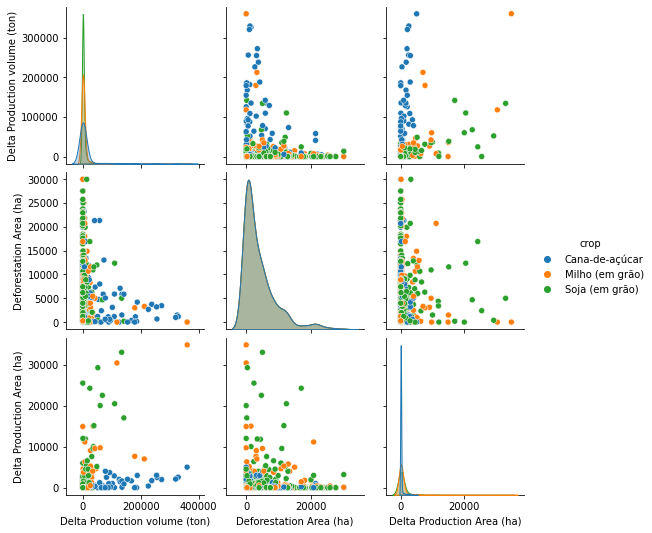

In [24]:
import seaborn as sns 
sns.pairplot(main_cultures_complete_df[['Delta Production volume (ton)', 'Deforestation Area (ha)', 'Delta Production Area (ha)', 'crop']], hue='crop')

In [25]:
delta_df_pecuaria = delta_df.query('type == "pecuaria"')

complete_df_pecuaria = pantanal_deforestation_df[['location', 'year', 'deforestation_ha']].merge(
    delta_df_pecuaria,
    on=['location', 'year'],
    how='left'
)
complete_df_pecuaria['delta_cabecas'] = complete_df_pecuaria['delta_cabecas'].astype('float')

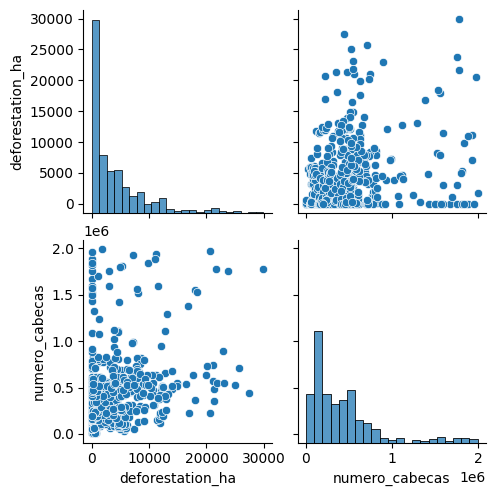

In [26]:
sns.pairplot(complete_df_pecuaria[['deforestation_ha', 'numero_cabecas']])

In [27]:
chart = alt.Chart(complete_df_pecuaria).mark_point(color='green').encode(
    x=alt.X('delta_cabecas', axis=alt.Axis(title='Number of livestock heads')),
    y=alt.Y('deforestation_ha', axis=alt.Axis(title='Delta Deforestation (ha)')),
)

reg_chart = (
    chart + 
    chart.transform_regression(
        'delta_cabecas', 'deforestation_ha'
    ).mark_line(
        color='red', strokeDash=[2]
    )
)

# text = alt.Chart({'values':[{}]}).mark_text(
#     align="left", baseline="top", size=15, color='red', angle=350
# ).encode(
#     x=alt.value(400),  # pixels from left
#     y=alt.value(370),  # pixels from top
#     text=alt.value("y = 2337.35 + 0.0039 * x"))

text2 = alt.Chart({'values':[{}]}).mark_text(
    align="left", baseline="top", size=15, color='red',
).encode(
    x=alt.value(20),  # pixels from left
    y=alt.value(20),  # pixels from top
    text=alt.value("R^2 = 9.74%"))

reg_chart = reg_chart + text2 #+ text

final_chart = reg_chart.properties(
    width=750,
    height=500,
    title=science_theme_title(
        text="Linear regression of Deforestation X Number of livestock heads", 
        subtitle="1985-2020"
    )
)

final_chart

alt.LayerChart(...)

In [28]:
df_train = complete_df_pecuaria[['delta_cabecas', 'deforestation_ha']].dropna()
df_train.corr()

,delta_cabecas,deforestation_ha
delta_cabecas,1.000000,0.245883
deforestation_ha,0.245883,1.000000
